Generating Chart 1 (Metrics)...
Generating Chart 2 (Interventions)...
Saved: chart_1_metrics_final_v3.png/.pdf AND chart_2_events_final_v3.png/.pdf


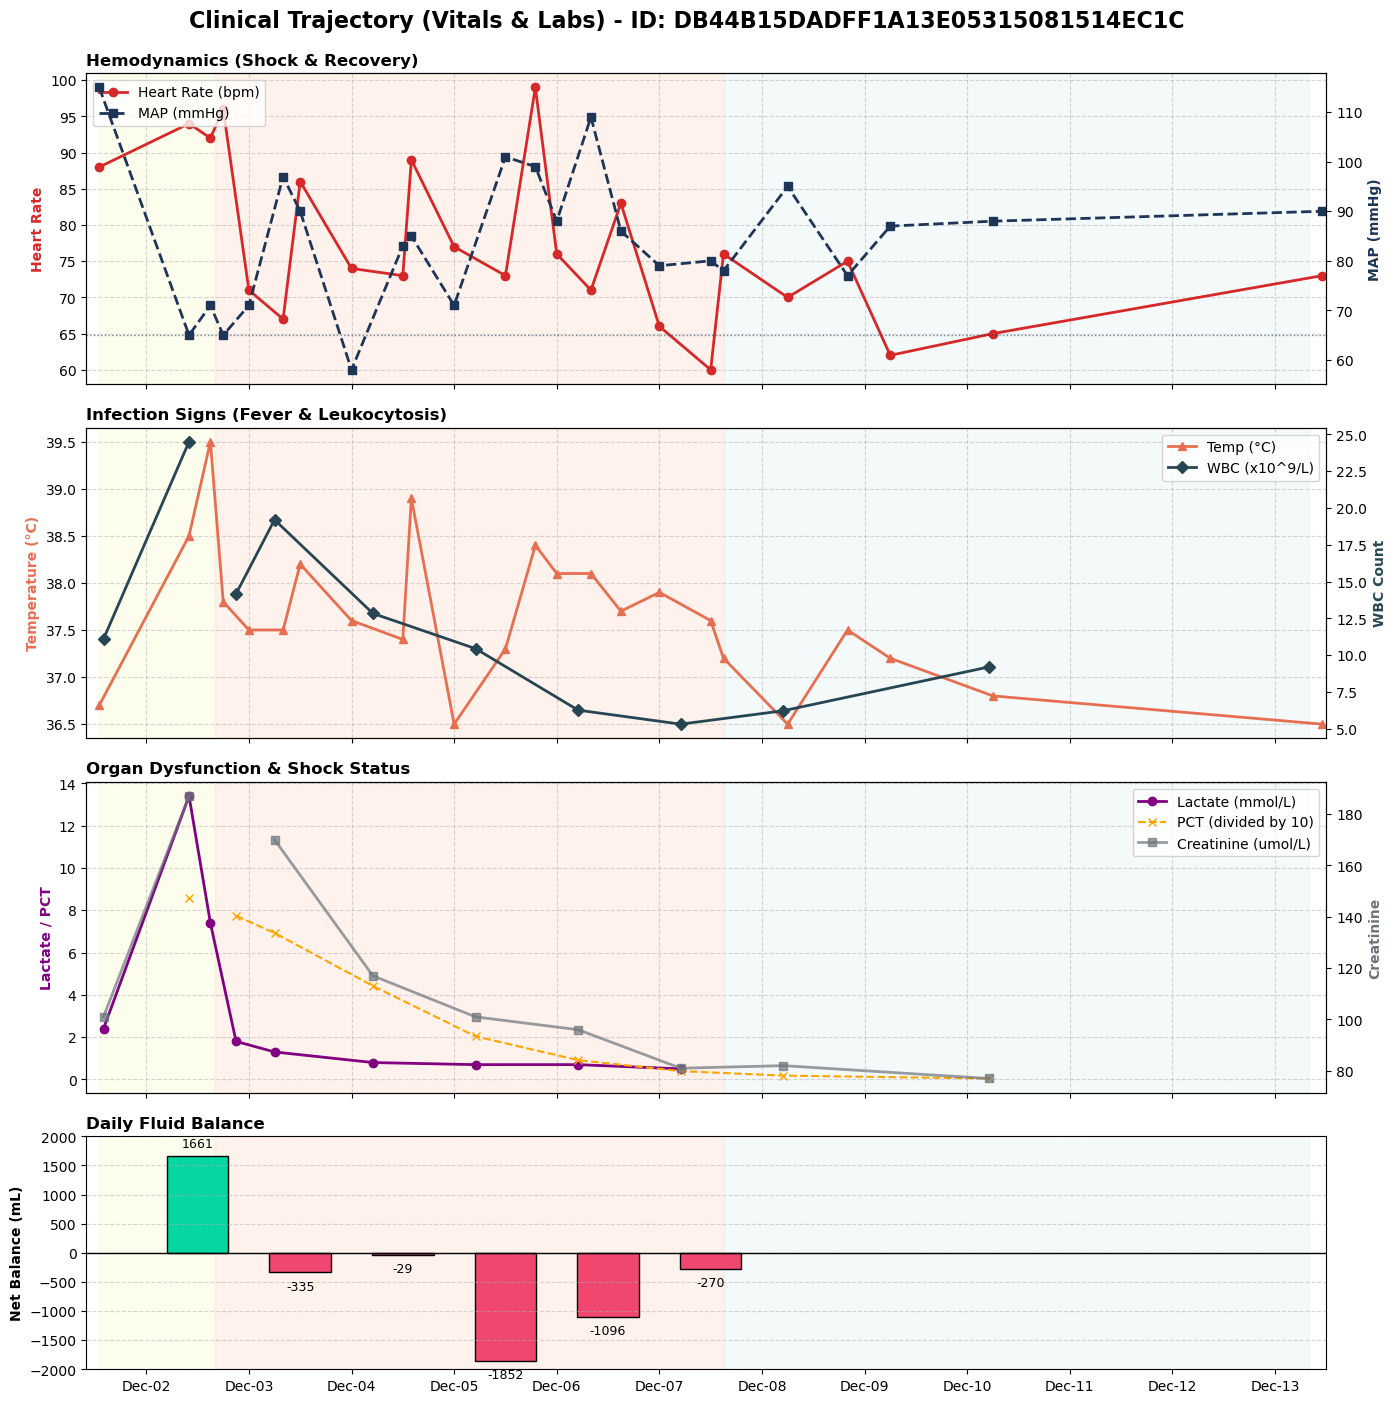

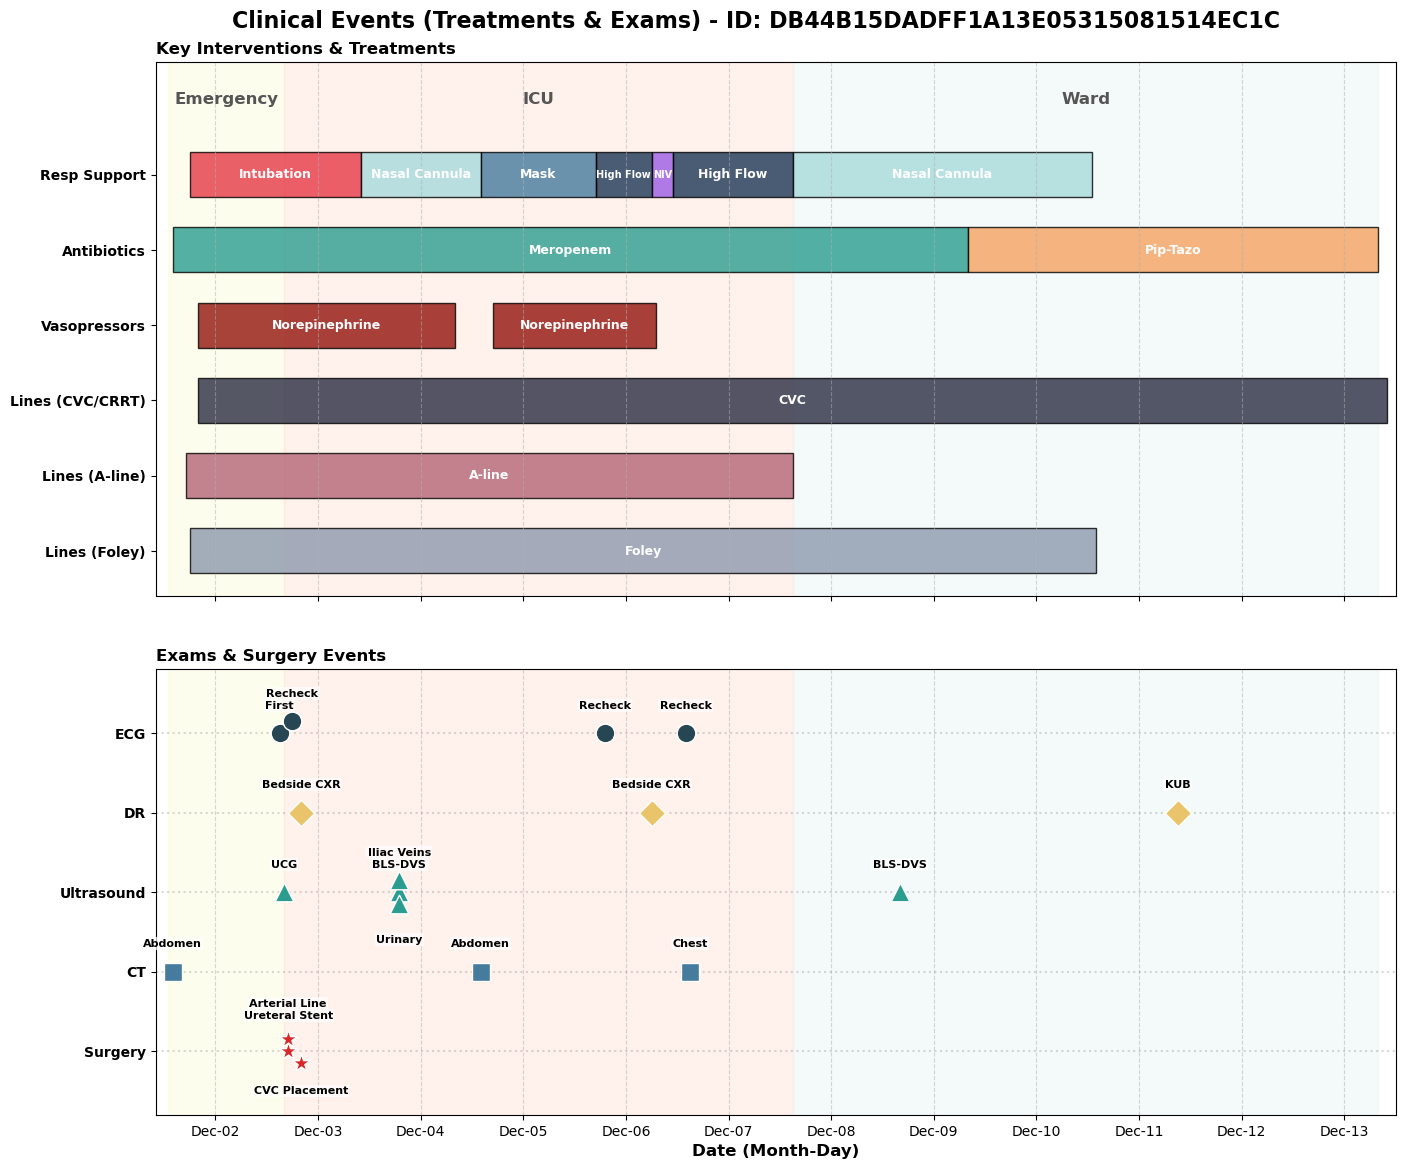

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.patches as mpatches

# ==========================================
# 1. Data Preparation (REAL DATA)
# ==========================================

# --- ID ---
PATIENT_ID = "DB44B15DADFF1A13E05315081514EC1C"

# --- Stages ---
stages_data = """stage,start,end
Emergency,12.1.13,12.2.16
ICU,12.2.16,12.7.15
Ward,12.7.15,12.13.8
"""

# --- Vitals ---
vitals_data = """time,HR,MAP,Temp
12.1.13,88,115,36.7
12.2.10,94,65,38.5
12.2.15,92,71,39.5
12.2.18,96,65,37.8
12.3.00,71,71,37.5
12.3.08,67,97,37.5
12.3.12,86,90,38.2
12.4.00,74,58,37.6
12.4.12,73,83,37.4
12.4.14,89,85,38.9
12.5.00,77,71,36.5
12.5.12,73,101,37.3
12.5.19,99,99,38.4
12.6.00,76,88,38.1
12.6.08,71,109,38.1
12.6.15,83,86,37.7
12.7.00,66,79,37.9
12.7.12,60,80,37.6
12.7.15,76,78,37.2
12.8.06,70,95,36.5
12.8.20,75,77,37.5
12.9.06,62,87,37.2
12.10.06,65,88,36.8
12.13.11,73,90,36.5
"""

# --- Labs ---
labs_data = """time,WBC,PCT,Lac,Cr
12.1.14,11.1,nan,2.4,101
12.2.10,24.5,86.02,13.4,187
12.2.15,nan,nan,7.4,nan
12.2.21,14.17,77.35,1.8,nan
12.3.06,19.2,69.27,1.3,170
12.4.05,12.84,44.21,0.8,117
12.5.05,10.45,20.40,0.7,101
12.6.05,6.27,9.13,0.7,96
12.7.05,5.32,3.93,0.5,81
12.8.05,6.23,1.82,nan,82
12.10.05,9.2,0.46,nan,77
"""

# --- Fluid Balance ---
fluid_data = """date,balance
12.2,1661.8
12.3,-335.7
12.4,-29.5
12.5,-1852.5
12.6,-1096.5
12.7,-270
"""

# --- Treatments (Modified: Split Abx, Extended Vaso) ---
treatments_list = [
    # Respiratory
    ('Resp', 'Intubation',    '12.1.18', '12.3.10', '#e63946'),
    ('Resp', 'Nasal Cannula', '12.3.10', '12.4.14', '#a8dadc'),
    ('Resp', 'Mask',          '12.4.14', '12.5.17', '#457b9d'),
    ('Resp', 'High Flow',     '12.5.17', '12.6.06', '#1d3557'),
    ('Resp', 'NIV',           '12.6.06', '12.6.11', '#9b5de5'), 
    ('Resp', 'High Flow',     '12.6.11', '12.7.15', '#1d3557'),
    ('Resp', 'Nasal Cannula', '12.7.15', '12.10.13', '#a8dadc'),
    
    # Antibiotics (Modified: Split Meropenem and Pip-Tazo)
    # Meropenem covers first ~2/3 (Dec 1 to Dec 9)
    ('Abx', 'Meropenem',      '12.1.14', '12.9.08', '#2a9d8f'),
    # Piperacillin-Tazobactam covers last ~1/3 (Dec 9 to Dec 13)
    ('Abx', 'Pip-Tazo',       '12.9.08', '12.13.08', '#f4a261'), 

    # Vasopressors (Modified: Duration Doubled)
    # Original: 12.2.20 -> 12.3.02. New: -> 12.3.08 (Approx double)
    ('Vaso', 'Norepinephrine', '12.1.20', '12.4.08', '#92140c'), 
    # Original: 12.4.17 -> 12.5.00. New: -> 12.5.07 (Approx double)
    ('Vaso', 'Norepinephrine', '12.4.17', '12.6.07', '#92140c'), 
    
    # Lines (3 Categories)
    ('Lines_Foley', 'Foley',         '12.1.18', '12.10.14', '#8d99ae'),
    ('Lines_Access', 'CVC',     '12.1.20', '12.13.10', '#2b2d42'),
    ('Lines_Art',   'A-line',        '12.1.17', '12.7.15',  '#b56576'),
]

# --- Exams & Surgery ---
exams_raw = """id,type,event,time
4245046,CT,Abdomen,12.1.14
4245046,ECG,First,12.2.15
4245045,Ultrasound,UCG,12.2.16
4245046,ECG,Recheck,12.2.18
4245046,DR,Bedside CXR,12.2.20
4245046,Ultrasound,BLS-DVS,12.3.19
4245046,Ultrasound,Iliac Veins,12.3.19
4245046,Ultrasound,Urinary,12.3.19
4245046,CT,Abdomen,12.4.14
4245046,ECG,Recheck,12.5.19
4245046,DR,Bedside CXR,12.6.06
4245046,ECG,Recheck,12.6.14
4245046,CT,Chest,12.6.15
4245046,Ultrasound,BLS-DVS,12.8.16
4245046,DR,KUB,12.11.09
4245043,Surgery,Ureteral Stent,12.2.17
4245044,Surgery,CVC Placement,12.2.20
4245045,Surgery,Arterial Line,12.2.17
"""

# ==========================================
# 2. Parsing Helpers
# ==========================================
def parse_date(date_str, default_hour=12):
    try:
        parts = str(date_str).split('.')
        month = int(parts[0])
        day = int(parts[1])
        hour = int(parts[2]) if len(parts) > 2 else default_hour
        year = 2024
        if month == 1: year = 2025
        return pd.Timestamp(year=year, month=month, day=day, hour=hour)
    except:
        return pd.NaT

# Data Loading
df_stages = pd.read_csv(StringIO(stages_data))
df_stages['start'] = df_stages['start'].apply(parse_date)
df_stages['end'] = df_stages['end'].apply(parse_date)

df_vitals = pd.read_csv(StringIO(vitals_data))
df_vitals['time'] = df_vitals['time'].apply(parse_date)

df_labs = pd.read_csv(StringIO(labs_data))
df_labs['time'] = df_labs['time'].apply(parse_date)

df_fluids = pd.read_csv(StringIO(fluid_data))
df_fluids['date_ts'] = df_fluids['date'].apply(lambda x: parse_date(x, default_hour=12))

df_exams = pd.read_csv(StringIO(exams_raw))
df_exams['time'] = df_exams['time'].apply(parse_date)
df_exams = df_exams[(df_exams['time'].dt.month == 12) & (df_exams['time'].dt.year == 2024)].sort_values('time')

tx_data = []
for cat, name, start, end, color in treatments_list:
    tx_data.append({'Category': cat, 'Name': name, 'Start': parse_date(start), 'End': parse_date(end), 'Color': color})
df_tx = pd.DataFrame(tx_data)

# Common X Limits
xmin = parse_date("12.1.10")
xmax = parse_date("12.13.12")

# Helper for Stages
def draw_stages(ax, label=False, label_y=4.0):
    colors = {'Emergency': '#fdfcdc', 'ICU': '#ffe5d9', 'Ward': '#eaf4f4'}
    for _, row in df_stages.iterrows():
        ax.axvspan(row['start'], row['end'], color=colors.get(row['stage'], 'white'), alpha=0.5, zorder=0)
        if label:
            # Place label high up
            mid_point = row['start'] + (row['end'] - row['start']) / 2
            ax.text(mid_point, label_y, row['stage'], ha='center', va='center', 
                    fontsize=12, fontweight='bold', color='#555')

# ==========================================
# CHART 1: Clinical Metrics (Vitals, Labs, Fluids)
# ==========================================
print("Generating Chart 1 (Metrics)...")
fig1, axes1 = plt.subplots(nrows=4, ncols=1, figsize=(16, 16), sharex=True, 
                           gridspec_kw={'height_ratios': [2, 2, 2, 1.5]})

plt.subplots_adjust(hspace=0.15, top=0.92) 
fig1.suptitle(f'Clinical Trajectory (Vitals & Labs) - ID: {PATIENT_ID}', fontsize=16, weight='bold', y=0.96)

# --- 1. Hemodynamics ---
ax_hemo = axes1[0]
draw_stages(ax_hemo)
ax_hemo_twin = ax_hemo.twinx()
l1, = ax_hemo.plot(df_vitals['time'], df_vitals['HR'], 'o-', color='#d62828', label='Heart Rate (bpm)', linewidth=2)
l2, = ax_hemo_twin.plot(df_vitals['time'], df_vitals['MAP'], 's--', color='#1d3557', label='MAP (mmHg)', linewidth=2)
ax_hemo_twin.axhline(65, color='#1d3557', linestyle=':', alpha=0.6, linewidth=1)
ax_hemo.set_ylabel('Heart Rate', color='#d62828', fontweight='bold')
ax_hemo_twin.set_ylabel('MAP (mmHg)', color='#1d3557', fontweight='bold')
ax_hemo.set_title("Hemodynamics (Shock & Recovery)", loc='left', fontsize=12, fontweight='bold')
ax_hemo.grid(True, linestyle='--', alpha=0.5)
ax_hemo.legend(handles=[l1, l2], loc='upper left')

# --- 2. Infection ---
ax_inf = axes1[1]
draw_stages(ax_inf)
ax_inf_twin = ax_inf.twinx()
l3, = ax_inf.plot(df_vitals['time'], df_vitals['Temp'], '^-', color='#e76f51', label='Temp (°C)', linewidth=2)
l4, = ax_inf_twin.plot(df_labs['time'], df_labs['WBC'], 'D-', color='#264653', label='WBC (x10^9/L)', linewidth=2)
ax_inf.set_ylabel('Temperature (°C)', color='#e76f51', fontweight='bold')
ax_inf_twin.set_ylabel('WBC Count', color='#264653', fontweight='bold')
ax_inf.set_title("Infection Signs (Fever & Leukocytosis)", loc='left', fontsize=12, fontweight='bold')
ax_inf.grid(True, linestyle='--', alpha=0.5)
ax_inf.legend(handles=[l3, l4], loc='upper right')

# --- 3. Organ Dysfunction ---
ax_org = axes1[2]
draw_stages(ax_org)
ax_org_twin = ax_org.twinx()
l5, = ax_org.plot(df_labs['time'], df_labs['Lac'], 'o-', color='purple', label='Lactate (mmol/L)', linewidth=2)
l6, = ax_org.plot(df_labs['time'], df_labs['PCT']/10, 'x--', color='orange', label='PCT (divided by 10)', linewidth=1.5)
l7, = ax_org_twin.plot(df_labs['time'], df_labs['Cr'], 's-', color='#6c757d', label='Creatinine (umol/L)', linewidth=2, alpha=0.7)
ax_org.set_ylabel('Lactate / PCT', color='purple', fontweight='bold')
ax_org_twin.set_ylabel('Creatinine', color='#6c757d', fontweight='bold')
ax_org.set_title("Organ Dysfunction & Shock Status", loc='left', fontsize=12, fontweight='bold')
ax_org.grid(True, linestyle='--', alpha=0.5)
lines = [l5, l6, l7]
ax_org.legend(lines, [l.get_label() for l in lines], loc='upper right')

# --- 4. Fluid Balance ---
ax_fluid = axes1[3]
draw_stages(ax_fluid)
colors = ['#ef476f' if x < 0 else '#06d6a0' for x in df_fluids['balance']]
ax_fluid.bar(df_fluids['date_ts'], df_fluids['balance'], color=colors, edgecolor='black', width=0.6)
ax_fluid.axhline(0, color='black', linewidth=1)
ax_fluid.set_ylabel('Net Balance (mL)', fontweight='bold')
ax_fluid.set_title("Daily Fluid Balance", loc='left', fontsize=12, fontweight='bold')
ax_fluid.grid(axis='y', linestyle='--', alpha=0.5)
ax_fluid.set_ylim(-2000, 2000)
for i, row in df_fluids.iterrows():
    y_pos = row['balance'] + 150 if row['balance'] > 0 else row['balance'] - 300
    ax_fluid.text(row['date_ts'], y_pos, f"{int(row['balance'])}", ha='center', fontsize=9)

locator = mdates.DayLocator()
formatter = mdates.DateFormatter('%b-%d')
ax_fluid.xaxis.set_major_locator(locator)
ax_fluid.xaxis.set_major_formatter(formatter)
plt.xlabel("Date (Month-Day)", fontsize=12, fontweight='bold')
ax_fluid.set_xlim(xmin, xmax)

# Legend REMOVED as requested

plt.savefig('chart_1_metrics_final_v3.png', dpi=300, bbox_inches='tight')
plt.savefig('chart_1_metrics_final_v3.pdf', bbox_inches='tight')

# ==========================================
# CHART 2: Interventions & Events
# ==========================================
print("Generating Chart 2 (Interventions)...")
fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(16, 13), sharex=True, 
                           gridspec_kw={'height_ratios': [1.2, 1]})

plt.subplots_adjust(hspace=0.15, top=0.92)
fig2.suptitle(f'Clinical Events (Treatments & Exams) - ID: {PATIENT_ID}', fontsize=16, weight='bold', y=0.96)

# --- 1. Treatments (Gantt) ---
ax_tx = axes2[0]
ax_tx.set_ylim(-0.6, 6.5) # Increased Y limit for Stage Labels
draw_stages(ax_tx, label=True, label_y=6.0)

# Updated Mapping: 6 rows
y_mapping = {
    'Resp': 5, 
    'Abx': 4, 
    'Vaso': 3, 
    'Lines_Access': 2, # CVC/CRRT
    'Lines_Art': 1,    # A-line
    'Lines_Foley': 0   # Foley
}
y_ticks_pos = [0, 1, 2, 3, 4, 5]
y_tick_labels = ['Lines (Foley)', 'Lines (A-line)', 'Lines (CVC/CRRT)', 'Vasopressors', 'Antibiotics', 'Resp Support']

for _, row in df_tx.iterrows():
    y_pos = y_mapping[row['Category']]
    duration = row['End'] - row['Start']
    duration_hours = duration.total_seconds() / 3600
    mid_point = row['Start'] + duration/2
    
    ax_tx.barh(y_pos, duration, left=row['Start'], height=0.6, color=row['Color'], edgecolor='black', alpha=0.8)
    
    font_size = 9
    if duration_hours < 16: font_size = 7
    ax_tx.text(mid_point, y_pos, row['Name'], ha='center', va='center', 
             color='white', fontsize=font_size, fontweight='bold')

ax_tx.set_yticks(y_ticks_pos)
ax_tx.set_yticklabels(y_tick_labels, fontsize=10, fontweight='bold')
ax_tx.set_title("Key Interventions & Treatments", loc='left', fontsize=12, fontweight='bold')
ax_tx.grid(axis='x', linestyle='--', alpha=0.5)

# --- 2. Exams & Surgery (Fixing Overlaps) ---
ax_exam = axes2[1]
draw_stages(ax_exam, label=False)
exam_types = ['Surgery', 'CT', 'Ultrasound', 'DR', 'ECG']
y_exam_map = {t: i for i, t in enumerate(exam_types)}
colors_map = {'Surgery': '#d62828', 'CT': '#457b9d', 'Ultrasound': '#2a9d8f', 'DR': '#e9c46a', 'ECG': '#264653'}
markers_map = {'Surgery': '*', 'CT': 's', 'Ultrasound': '^', 'DR': 'D', 'ECG': 'o'}

for y in range(len(exam_types)):
    ax_exam.axhline(y, color='gray', linestyle=':', alpha=0.3)

# Logic to prevent overlap: Jitter logic
df_exams = df_exams.sort_values(['type', 'time'])
df_exams['y_offset'] = 0.0

for etype in exam_types:
    subset = df_exams[df_exams['type'] == etype]
    if len(subset) > 1:
        prev_time = None
        offset_toggle = 1
        for idx, row in subset.iterrows():
            if prev_time is not None:
                # If events are within 4 hours of each other, apply offset
                if (row['time'] - prev_time).total_seconds() < 3600 * 4:
                    df_exams.at[idx, 'y_offset'] = 0.15 * offset_toggle
                    offset_toggle *= -1 
                else:
                    offset_toggle = 1 # Reset
            prev_time = row['time']

for _, row in df_exams.iterrows():
    etype = row['type']
    if etype in y_exam_map:
        base_y = y_exam_map[etype]
        final_y = base_y + row['y_offset']
        
        ax_exam.scatter(row['time'], final_y, color=colors_map.get(etype, 'black'), 
                    marker=markers_map.get(etype, 'o'), s=180, zorder=3, edgecolors='white')
        
        # Smart label positioning
        if row['y_offset'] >= 0:
            label_y = final_y + 0.35
        else:
            label_y = final_y - 0.45
            
        if etype == 'Surgery': label_y += 0.1
        
        ax_exam.text(row['time'], label_y, row['event'], ha='center', va='center',
                 fontsize=8, fontweight='bold', color='black', 
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

ax_exam.set_yticks(list(y_exam_map.values()))
ax_exam.set_yticklabels(exam_types, fontsize=10, fontweight='bold')
ax_exam.set_title("Exams & Surgery Events", loc='left', fontsize=12, fontweight='bold')
ax_exam.grid(axis='x', linestyle='--', alpha=0.5)
ax_exam.set_ylim(-0.8, len(exam_types) - 0.2)

ax_exam.xaxis.set_major_locator(locator)
ax_exam.xaxis.set_major_formatter(formatter)
plt.xlabel("Date (Month-Day)", fontsize=12, fontweight='bold')
ax_exam.set_xlim(xmin, xmax)

# Legend REMOVED as requested

plt.savefig('chart_2_events_final_v3.png', dpi=300, bbox_inches='tight')
plt.savefig('chart_2_events_final_v3.pdf', bbox_inches='tight')

print("Saved: chart_1_metrics_final_v3.png/.pdf AND chart_2_events_final_v3.png/.pdf")
plt.show()